In [241]:
import pandas as pd
import seaborn as sns
import warnings
sns.set(style="white", palette="rainbow", color_codes=True)
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
warnings.filterwarnings('ignore')

In [242]:
region = ['Midwest', 'South', 'NewEngland']
import os
os.chdir('C:\\Users\\ziche\\Downloads\\LTV_DataSci_Capstone_Project')

In [243]:
ne_train = pd.read_csv("data\\ne_train.csv", parse_dates=True)
ne_train.head()
ne_test = pd.read_csv("data\\ne_test.csv", parse_dates=True)
s_train = pd.read_csv("data\\s_train.csv", parse_dates=True)
s_test = pd.read_csv("data\\s_test.csv",  parse_dates=True)

In [244]:
# function to filter columns 
def filter_col(raw_df):
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='grade_')))]
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='age_')))]
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='rolling_')))]
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='lagged_')))]
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='cat_')))]
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='diploma_')))]
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='college_')))]
    # rename the last column to "confirmed"
    # confirmed cases
    raw_df.rename(columns = {"covid_19_confirmed_cases": "confirmed"}, inplace=True)
    raw_df.rename(columns=lambda x: x.replace('num__', ''), inplace=True)
    raw_df['death'] = raw_df['deaths_per_100000'] * 100000
    # numerical columns
    raw_df['death'] = raw_df['death'].astype(float)
    ret = raw_df.drop(['deaths_per_100000'], axis=1, inplace=False)
    return ret


# apply filter_col function to all dataframes
ne_train = filter_col(ne_train)
ne_test = filter_col(ne_test)
s_train = filter_col(s_train)
s_test = filter_col(s_test)

In [245]:
# save to csv
ne_train.to_csv('models\\arima\\ne_train.csv')
ne_test.to_csv('models\\arima\\ne_test.csv')
s_train.to_csv('models\\arima\\s_train.csv')
s_test.to_csv('models\\arima\\s_test.csv')

In [246]:
NewEngland = ne_train.copy()

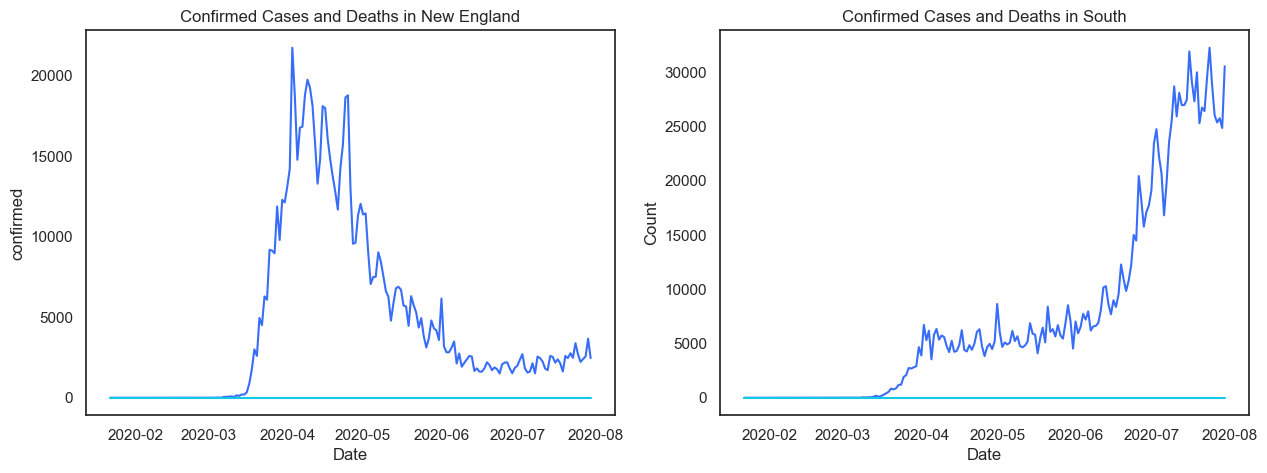

In [225]:
#side by side line plot of confirmed cases and deaths in New England and South
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x=ne_train.index, y='confirmed', data=ne_train, ax=axes[0])
sns.lineplot(x=ne_train.index, y='death', data=ne_train, ax=axes[0])
axes[0].set_title(f'Confirmed Cases and Deaths in New England')
axes[0].set_xlabel('Date')
# 
sns.lineplot(x=s_train.index, y='confirmed', data=s_train, ax=axes[1])
sns.lineplot(x=s_train.index, y='death', data=s_train, ax=axes[1])
axes[1].set_title(f'Confirmed Cases and Deaths in South')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Date')
plt.show()

## Correlation

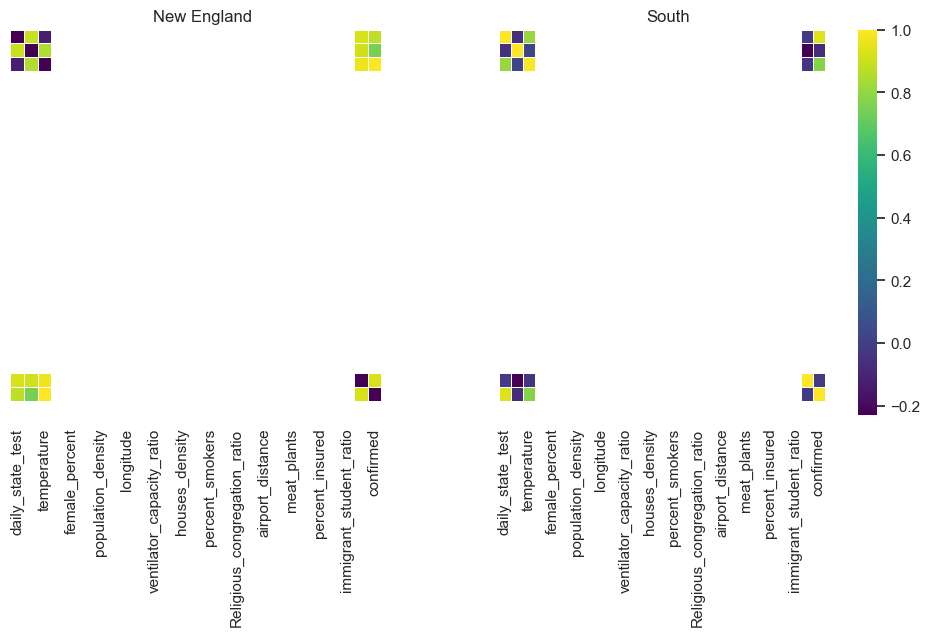

In [227]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(ne_train.corr(), cmap='viridis_r', cbar = False, annot = False, square = True, linewidths=0.5, ax=axes[0], yticklabels=False).set_title(f'New England')
# do not show feature name in heatmap
sns.heatmap(s_train.corr(), cmap='viridis', annot = False, linewidths=0.5, ax=axes[1], yticklabels=False).set_title(f'South')
plt.show()

#### Lagged Features

##### New England

In [247]:
NewEngland.head()

,date,daily_state_test,precipitation,temperature,total_population,female_percent,area,population_density,latitude,longitude,...,airport_distance,passenger_load_ratio,meat_plants,median_household_income,percent_insured,gdp_per_capita,immigrant_student_ratio,weekend,confirmed,death
0,2020-01-22,-1.187911,-0.684305,-1.933005,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,-0.627822,0.0,-2.273737e-08
1,2020-01-23,-1.187817,-0.685325,-1.561961,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,-0.627822,0.0,-2.273737e-08
2,2020-01-24,-1.187911,-0.685325,-1.205844,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,-0.627822,0.0,-2.273737e-08
3,2020-01-25,-1.187911,-0.004785,-0.910484,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,1.592808,0.0,-2.273737e-08
4,2020-01-26,-1.187911,4.583247,-0.764385,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,1.592808,0.0,-2.273737e-08


In [250]:
NewEngland.groupby(ne_train.index).sum()

,date,daily_state_test,precipitation,temperature,total_population,female_percent,area,population_density,latitude,longitude,...,airport_distance,passenger_load_ratio,meat_plants,median_household_income,percent_insured,gdp_per_capita,immigrant_student_ratio,weekend,confirmed,death
0,2020-01-22,-1.187911,-0.684305,-1.933005,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,-0.627822,0.0,-2.273737e-08
1,2020-01-23,-1.187817,-0.685325,-1.561961,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,-0.627822,0.0,-2.273737e-08
2,2020-01-24,-1.187911,-0.685325,-1.205844,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,-0.627822,0.0,-2.273737e-08
3,2020-01-25,-1.187911,-0.004785,-0.910484,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,1.592808,0.0,-2.273737e-08
4,2020-01-26,-1.187911,4.583247,-0.764385,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,1.592808,0.0,-2.273737e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,2020-07-26,1.313191,-0.656549,1.488973,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,1.592808,2226.0,-2.273737e-08
187,2020-07-27,1.343108,-0.519009,1.623884,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,-0.627822,2403.0,-2.273737e-08
188,2020-07-28,1.128799,0.339972,1.714657,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,-0.627822,2562.0,-2.273737e-08
189,2020-07-29,1.687415,-0.482184,1.443607,-2.910383e-11,2.220446e-16,-2.273737e-13,2.273737e-13,7.105427e-15,1.421085e-14,...,1.421085e-14,-8.326673e-17,0.0,-1.455192e-11,2.842171e-14,1.421085e-14,-3.469447e-18,-0.627822,3666.0,-2.273737e-08


In [251]:
NewEngland_daily = NewEngland.confirmed.groupby(NewEngland.index).sum()
NewEngland_daily

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
        ...  
186    2226.0
187    2403.0
188    2562.0
189    3666.0
190    2464.0
Name: confirmed, Length: 191, dtype: float64

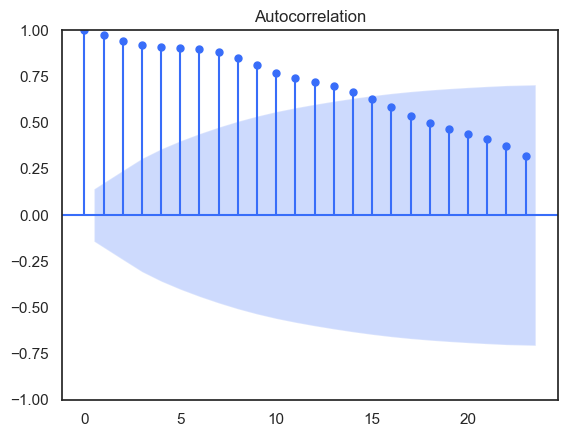

In [252]:
plot_acf(NewEngland_daily.dropna())
plt.show()

The first step would be to determine the order of differencing “d”, so we first check the autocorrelation plot. The autocorrelation plot above suggests that the NewEngland confirmed cases data is not ideal for the ARIMA model to directly start autoregressive training. So we do first differencing to see how it looks as following.

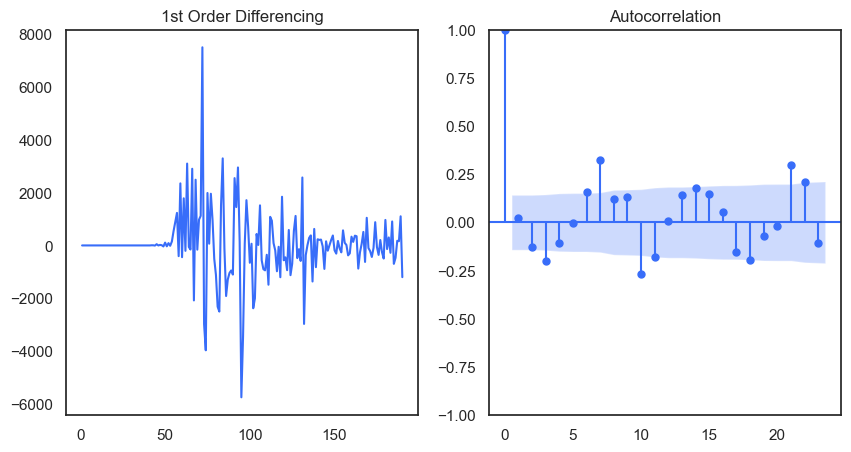

In [256]:
ne_diff1 = NewEngland_daily.diff().dropna()

f = plt.figure(figsize=(10, 5))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(ne_diff1)

ax2 = f.add_subplot(122)
plot_acf(ne_diff1, ax=ax2)
plt.show()

- As seen above, first-order differencing makes our series look fairly close to a stationary series but some lagged terms exceeded the bounds, suggesting the data is over-difference. Thus, we choose 0 as d for ARIMA(p,d,q) model at current stage. However, a more mathematical test can be employed to determine which order is best for the data in question. 
- With Augmented Dickey-Fuller test below, we see that the null hypothesis is not rejected for the original series, and also not rejected for the first differencing series, as both the p-values are greater than 0.05.

In [257]:
orgresult = adfuller(NewEngland_daily.dropna())
print('p-value: ', orgresult[1])

p-value:  0.10061645305278616


In [258]:
diff1result = adfuller(ne_diff1)
print('p-value: ', diff1result[1])

p-value:  0.21033084588491957


So we conduct second differening and conduct test as below. Both the ACF plot and result of test suggest a stationary series.

In [259]:
ne_diff2 = NewEngland_daily.diff().diff().dropna()
diff2result = adfuller(ne_diff2)
print('p-value: ', diff2result[1])

p-value:  2.3594594575099867e-25


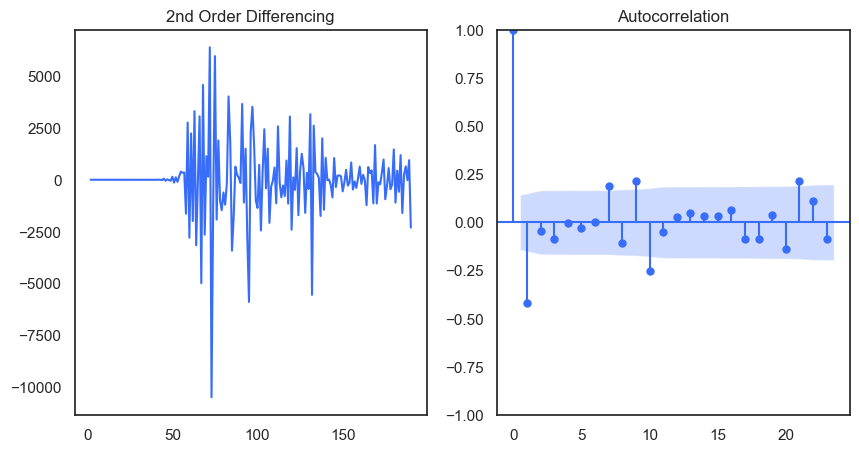

In [263]:

f = plt.figure(figsize=(10, 5))
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(ne_diff2)

ax2 = f.add_subplot(122)
plot_acf(ne_diff2, ax=ax2)
plt.show()

The next step in the ARIMA model is computing the order for the autoregressive model, denoted as 'p'. We determine “p” based on the most significant lag in the partial autocorrelation plot, as displayed below. We see the 1st lag is the most significant. Thus, we consider “p” to be 1.

For q, we refer to ACF. Since the ones with high correlation contribute more and would be enough to predict future values, we choose q=1 in our case.

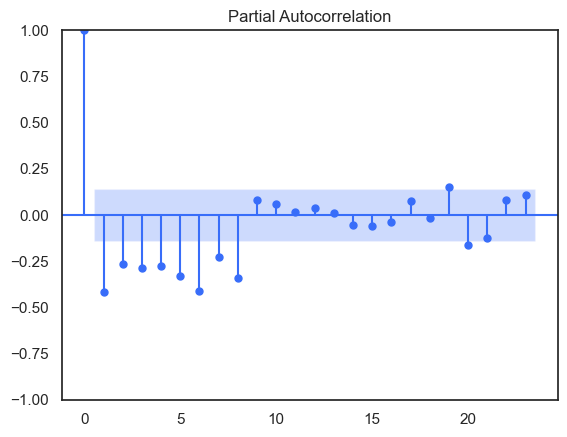

In [265]:
plot_pacf(ne_diff2)
plt.show()

In [266]:
arima_model_ne = ARIMA(NewEngland_daily, order=(1,2,1))
ne_model = arima_model_ne.fit()
print(ne_model.summary())

                               SARIMAX Results                                
Dep. Variable:              confirmed   No. Observations:                  191
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1617.793
Date:                Thu, 02 Nov 2023   AIC                           3241.585
Time:                        23:51:05   BIC                           3251.310
Sample:                             0   HQIC                          3245.525
                                - 191                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0269      0.039      0.693      0.488      -0.049       0.103
ma.L1         -1.0000      0.045    -22.109      0.000      -1.089      -0.911
sigma2      1.559e+06    2.9e-08   5.37e+13      0.0

##### South

In [268]:
South = s_train.copy()

In [269]:
South_daily = South.confirmed.groupby(South.index).sum()
South_daily

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
        ...   
186    26039.0
187    25366.0
188    25758.0
189    24859.0
190    30545.0
Name: confirmed, Length: 191, dtype: float64

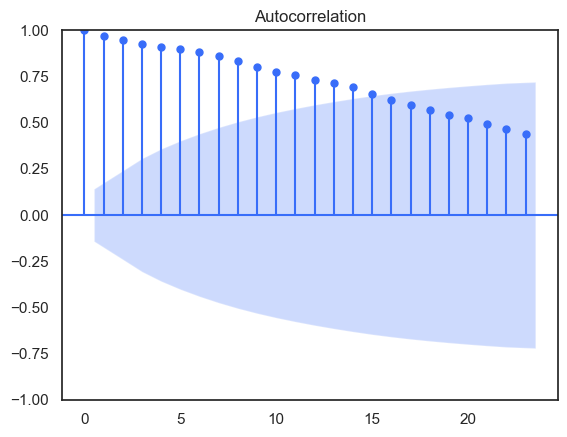

In [270]:
plot_acf(South_daily.dropna())
plt.show()

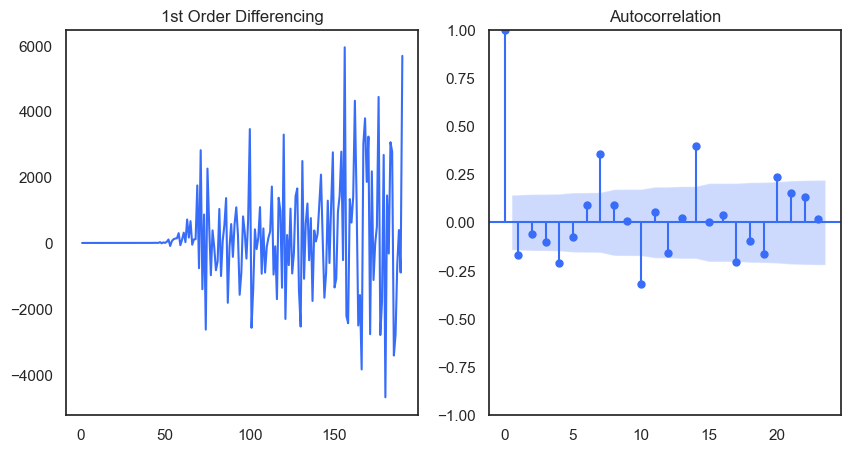

In [283]:
s_diff1 = South_daily.diff().dropna()

f = plt.figure(figsize=(10, 5))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(s_diff1)

ax2 = f.add_subplot(122)
plot_acf(s_diff1, ax=ax2)
plt.show()

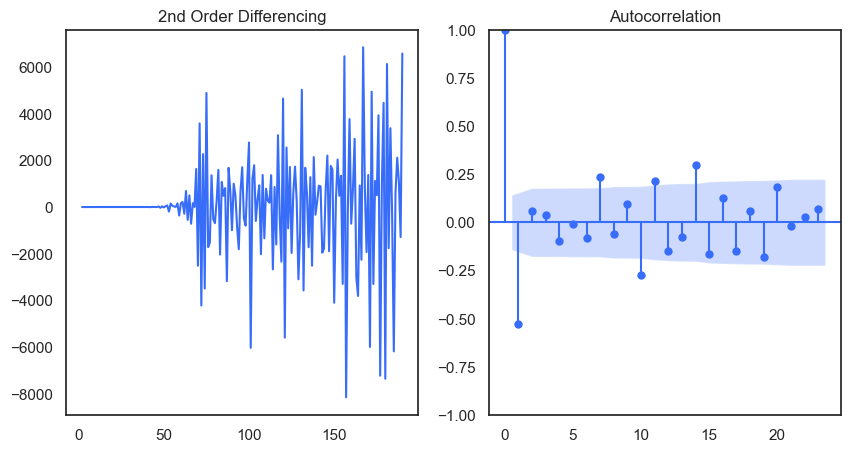

In [282]:
s_diff2 = South_daily.diff().diff().dropna()

f = plt.figure(figsize=(10, 5))
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(s_diff2)

ax2 = f.add_subplot(122)
plot_acf(s_diff2, ax=ax2)
plt.show()

In [273]:
orgresult = adfuller(South_daily.dropna())
print('p-value: ', orgresult[1])

p-value:  0.9217172564737497


In [274]:
diff1result = adfuller(s_diff1)
print('p-value: ', diff1result[1])

p-value:  0.14743712366200418


In [275]:
diff2result = adfuller(s_diff2)
print('p-value: ', diff2result[1])

p-value:  1.0049945437660795e-08


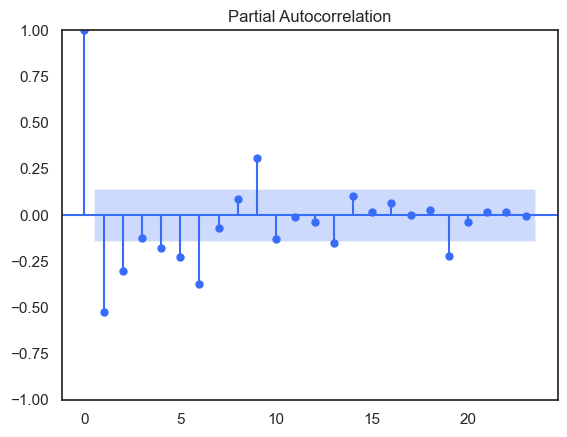

In [276]:
plot_pacf(s_diff2)
plt.show()

In [277]:
arima_model_s = ARIMA(South_daily, order=(1,2,1))
s_model = arima_model_s.fit()
print(s_model.summary())

                               SARIMAX Results                                
Dep. Variable:              confirmed   No. Observations:                  191
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1651.387
Date:                Thu, 02 Nov 2023   AIC                           3308.773
Time:                        23:51:27   BIC                           3318.499
Sample:                             0   HQIC                          3312.713
                                - 191                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1782      0.055     -3.213      0.001      -0.287      -0.069
ma.L1         -0.9992      0.113     -8.811      0.000      -1.221      -0.777
sigma2      2.224e+06   2.58e+05      8.631      0.0